# All Ireland M.bovis strain diversity and clade identification

In [ ]:
import sys,os,io,shutil,subprocess
import glob
from importlib import reload
import numpy as np
import pandas as pd
pd.set_option('display.width', 200)
import pylab as plt
import matplotlib as mpl
from Bio import SeqIO
import seaborn as sns
sys.path.append('pathogenie')
from snipgenie import tools, aligners, app, trees, plotting, rdiff, clustering
import toytree, toyplot
#import toyplot.pdf
path = '/storage/btbgenie/all_ireland_results'

## get meta data

In [66]:
meta = pd.read_csv('/storage/btbgenie/mbovis_ireland/all_ireland_samples.csv')
#meta = pd.read_csv('/storage/btbgenie/monaghan/metadata/isolates_master.csv')
print (len(meta))

3443


In [3]:
dups=meta[meta.duplicated('Aliquot')].dropna()
#print (dups)
for i,r in dups.iterrows():
    print (meta[meta.aliquot== r.aliquot])
#meta[(meta.batch.isin([2,3,4])) & (~meta.aliquot.isin(dups.aliquot)) & (meta.county=='Monaghan')]

## run AFBI non border

In [ ]:
reload(app)
args = {'threads':12, 'outdir': '/storage/btbgenie/AFBI_results', 'labelsep':'_',
        'input':['/storage/btbgenie/mbovis_ireland/AFBI_misc/'],
         'species': 'Mbovis-AF212297',
         'overwrite':False,
         'custom_filters': True,
         'buildtree':True}
W = app.WorkFlow(**args)
st = W.setup()
W.run()

## run NI

In [ ]:
reload(app)
args = {'threads':16, 'outdir': '/storage/btbgenie/NI_results', 'labelsep':'_',
        'input':['/storage/btbgenie/mbovis_ireland/NI/'],
         'species': 'Mbovis-AF212297',
         'overwrite':False,
         'custom_filters': True,
         'buildtree':True}
W = app.WorkFlow(**args)
st = W.setup()
W.run()

## misc samples (Ireland non-Monaghan)

In [ ]:
reload(app)
args = {'threads':12, 'outdir': '/storage/btbgenie/misc_results', 'labelsep':'_',
        'input':['/storage/btbgenie/mbovis_ireland/Misc'],
         'species': 'Mbovis-AF212297',
         'overwrite':False,
         'custom_filters': True,
         'get_stats':False,
         'buildtree':True}
W = app.WorkFlow(**args)
st = W.setup()
W.run()

In [ ]:
#samples=pd.read_csv('/storage/btbgenie/misc_results/samples.csv')
#app.clean_bam_files(samples, '/storage/btbgenie/misc_results/mapped/', remove=True)

In [ ]:
reload(app)
mask='/home/farrell/gitprojects/snipgenie/snipgenie/data/Mbovis_AF212297_mask.bed'
vcf_file='/storage/btbgenie/misc_results/snps.vcf.gz'
app.mask_filter(vcf_file, mask)

In [244]:
present=pd.read_csv('/storage/btbgenie/misc_results/summary.csv')
present['sample']=present['sample'].astype(str)
#print (present[:10])
l=list(W.fastq_table['sample'].unique())

s=meta[meta.batch>=3].sort_values(by='sample')
#s['label'] = s['sample'].apply(lambda x : x.split('-')[1][-4:]).astype(str)
#s=s.sort_values('label')

p = present[~present['sample'].isin(s['sample'])]
#p = (s[s['label'].isin(l)])
print (p)
print (len(s),len(p), len(present))

         sample                           name                                           bam_file  read_length
25  TB19-004280  TB19-004280_S68_L001-4_R2_001  /storage/btbgenie/misc_results/mapped/TB19-004...          149
48  TB19-005887  TB19-005887_S29_L001-4_R2_001  /storage/btbgenie/misc_results/mapped/TB19-005...          150
65 2 61


## integrate previously aligned bam files together and call variants

This allows us to join previously mapped results together in one call without re-aligning

In [4]:
outdir='/storage/btbgenie/all_ireland_results'

folders = {'wicklow':'/storage/btbgenie/wicklow_results',        
          'misc':'/storage/btbgenie/misc_results',
          'monaghan':'/storage/btbgenie/monaghan/monaghan_results',
          'NI':'/storage/btbgenie/AFBI_results/',
          'UK':'/storage/btbgenie/UK_results'
          }

x=[]
for f in folders:    
    file = os.path.join(folders[f],'samples.csv')   
    df=pd.read_csv(file)
    df['group'] = f
    x.append(df)
    print (f, len(df))
samples = pd.concat(x)
print (len(samples))
samples.to_csv('/storage/btbgenie/all_ireland_results/samples.csv',index=False)
app.write_samples(samples[['sample']], outdir)
bam_files = list(samples.bam_file)

wicklow 48
misc 273
monaghan 727
NI 208
UK 179
1435


In [ ]:
s=list(samples[samples.duplicated('sample')]['sample'])
#samples[samples['sample'].isin(s)]
s

## run previously aligned files

In [ ]:
reload(app)
gff_file=os.path.join(outdir,'mbovis.gff')
tools.gff_bcftools_format(app.mbovis_gb, gff_file)
app.run_bamfiles(bam_files, app.mbovis_genome, outdir='/storage/btbgenie/all_ireland_results', threads=12,                
                 mask=app.mbovis_mask, gff_file=gff_file,
                 custom_filters=True)

In [ ]:
from Bio import Align, pairwise2
import numpy as np

def distance_matrix(aln):
    """
    Compute the number of Single Nucleotide Polymorphisms (SNPs) between sequences in a Biopython alignment.
    """
    
    names=[s.id for s in aln]
    num_sequences = len(aln)
    matrix = np.zeros((num_sequences, num_sequences))

    for i in range(num_sequences):
        for j in range(i + 1, num_sequences):
            seq1 = str(aln[i].seq)
            seq2 = str(aln[j].seq)
            # Calculate the number of SNPs
            snp_count = sum(c1 != c2 for c1, c2 in zip(seq1, seq2))
            matrix[i, j] = snp_count
            matrix[j, i] = snp_count
            
    m = pd.DataFrame(matrix,index=names,columns=names).astype(int)
    return m

from Bio import AlignIO
aln = AlignIO.read('/storage/btbgenie/all_ireland_results/core.fa', 'fasta')
import time 
times=[]
x=[10,100,200,300,500,1000]
for n in x:
    st=time.time()
    a=aln[:n,:]
    d=distance_matrix(a)
    #d=tools.snp_dist_matrix(a)
    tt=time.time()-st
    print(tt)
    times.append(tt)
plt.plot(x,times)

In [56]:
a=aln[:20,:]
d=distance_matrix(a)
d2=tools.snp_dist_matrix(a)

## spoligotypes of all samples

In [ ]:
reload(tools)
spo = pd.read_csv('/storage/btbgenie/mbovis_ireland/spoligotypes.csv')
done=list(spo['sample'])
res=[]
for i,r in samples.iterrows():
    f=r.filename1
    samp=r['sample']
    if samp in done:
        continue
    b = tools.get_spoligotype(f)
    sb = tools.get_sb_number(b)
    print (f,samp,sb, b)
    res.append([f,samp,sb,b])
 
res = pd.DataFrame(res,columns=['filename','sample','SB','code'])
#append new spotypes to current file
res=pd.concat([spo,res])

In [7]:
len(res),len(meta)
#meta[~meta['sample'].isin(res['sample'])]
#res.to_csv('/storage/btbgenie/mbovis_ireland/spoligotypes.csv',index=False)

(1683, 3100)

<div class="alert alert-block alert-info"><b>Post analysis starts here</b> </div>

## clusters

In [63]:
#clusts = trees.get_clusters('/storage/btbgenie/all_ireland_results/tree.newick')
snpdist = pd.read_csv('/storage/btbgenie/all_ireland_results/snpdist.csv',index_col=0)
clusts,members = clustering.get_cluster_levels(snpdist)
import pickle
pickle.dump(members,open('/storage/btbgenie/cluster_members.pkl','wb'))

In [ ]:
cc = clusts.snp200.value_counts()[1:20]
cc.plot(kind='bar',figsize=(12,5))
print (list(cc.index))

## strain names

In [64]:
st = clustering.generate_strain_names(clusts,snpdist)

In [67]:
common = meta.County.value_counts()[:8]
def cty_comm(x):
    if x in common:
        return x
    else:
        return 'Other'
meta['county1'] = meta.County.apply(cty_comm)
meta['county2'] = meta.County.apply(lambda x : x if x in ['Monaghan','Clare'] else 'Other')
common

Monaghan     449
UK           352
Cork         193
Clare        179
Meath        132
Tipperary    111
Armagh       107
Wicklow      107
Name: County, dtype: int64

In [68]:
spo = pd.read_csv('/storage/btbgenie/mbovis_ireland/spoligotypes.csv')

In [ ]:
print (len(samples))
samples[~samples['sample'].isin(meta.SeqID)]


In [ ]:
final.iloc[0]

In [69]:
#final = meta.merge(samples,left_on='SeqID',right_on='sample',how='left')
final = samples.merge(meta,left_on='sample',right_on='SeqID',how='left')
final = final.merge(spo[['sample','SB']],on='sample',how='left')
final = final.merge(st,left_on='sample',right_index=True)
final = final.drop_duplicates('sample')
len(final)

1435

In [77]:
#final.SB.value_counts()

In [70]:
common = final.SB.value_counts()[:8]
def sb_comm(x):
    if x in common:
        return x
    else:
        return 'Other'
final['SB1'] = final.SB.apply(sb_comm)

In [71]:
final.to_csv('/storage/btbgenie/all_ireland_results/metadata.csv',index=False)

In [ ]:
reload(trees)
scol='snp200'
X=final.set_index('SeqID')
treefile='/storage/btbgenie/all_ireland_results/tree.newick'
trees.draw_tree(treefile,X,scol,width=600,cmap=clustering.snp200_cmap)

In [ ]:
cg = sns.clustermap(X, cmap='Blues', row_colors=X.color,figsize=(6,6))
cm=dict(zip(X[scol],X.color))
p=plotting.make_legend(cg.fig, cm, loc=(1.1, .6), title='cluster',fontsize=10)

## selected samples for IMRL

In [ ]:
#remove redunancy at snp level
x = final[final.group=='misc']
x['dup'] = x.snp20.replace(-1,np.nan)
x= x[(~x.duplicated('dup')) | (x.dup.isnull())]
x=x[~x['sample'].isin(['TB20-002600','TB20-001797','TB20-002596'])]
x.snp20.value_counts()
print (len(x))
#print (x)
from zipfile import ZipFile
zipObj = ZipFile('/storage/btbgenie/imrl_mbovis2.zip', 'w')
for i,r in x[20:40].iterrows():
    print (r['sample'])
    zipObj.write(r.filename1,os.path.basename(r.filename1))
    zipObj.write(r.filename2,os.path.basename(r.filename2))    
zipObj.close()

#print (list(x['sample']))

## RD analysis

In [ ]:
reload(rdiff)
rdiff.create_rd_index()
samples = pd.read_csv('/storage/btbgenie/all_ireland_results/samples.csv')
res = rdiff.run_samples(samples,'/storage/btbgenie/all_ireland_results/rd_aligned',threads=12)
X = rdiff.get_matrix(res, cutoff=0.15)
X['ident'] = X.apply(rdiff.apply_rules,1)
#X.to_csv('/storage/btbgenie/mbovis_ireland/rd.csv')

In [ ]:
R=pd.read_csv('/storage/btbgenie/mbovis_ireland/rd.csv',index_col=0)
R=R.iloc[:,:-1]
#cols=X.columns[(X.sum()<len(X)-1) & (X.sum()>0)]
cols = ['RD1','RD1mic','RDWicklow','RD11','RD12bov','RD13','RD149','RD3','RD5','RD5oryx*','RD122','RDAf2']
R = R[cols]
#fig,ax=plt.subplots(1,1,figsize=(10,10))
sns.clustermap(R,cmap='gray_r',figsize=(10,10))

In [ ]:
reload(rdiff)
samples = pd.read_csv('/storage/btbgenie/all_ireland_results/samples.csv')
sub=samples.sample(20,random_state=2)
regions = rdiff.get_deletions(sub, app.mbovis_genome, app.mbovis_gb, mask_file=app.mbovis_mask,
                              label='sample', min_coverage=0, n_cores=12)
regions.to_csv('deletion_regions.csv',index=False)

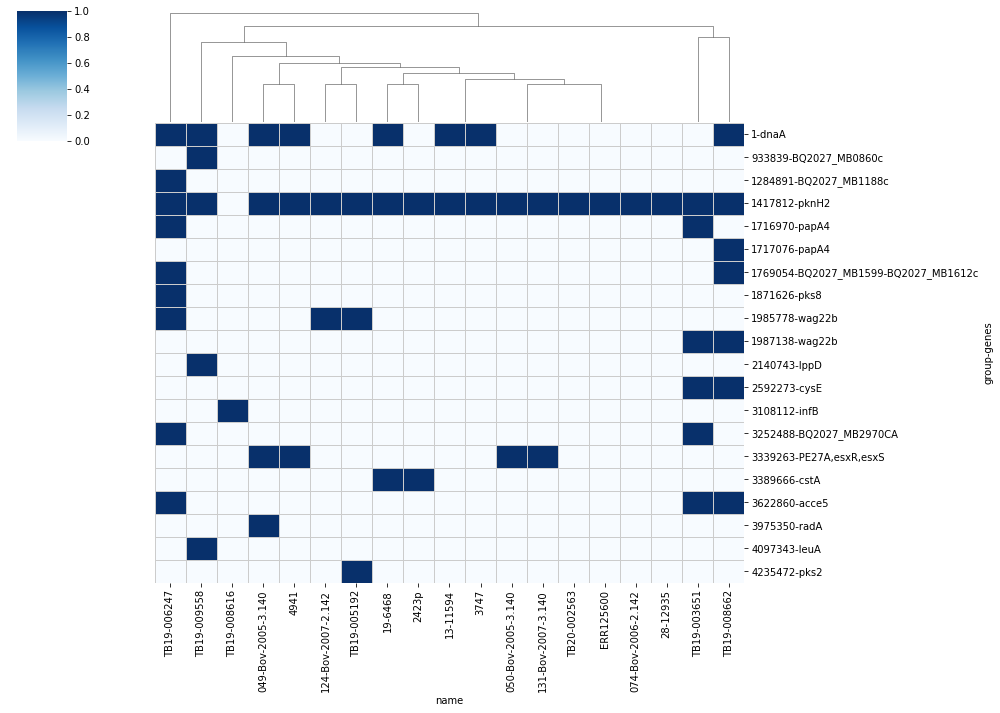

In [4]:
regions = pd.read_csv('deletion_regions.csv')
res=regions[regions.length>10]
X=pd.pivot_table(res,index=['group','genes'],columns='name',values='length').fillna(0)
X=X.clip(0,1)
X
sns.clustermap(X,cmap='Blues',row_cluster=False,yticklabels=True,lw=1,linecolor='.8',figsize=(14,10))

In [ ]:
reload(rdiff)
s=3339263;e=s+1000
rdiff.show_coverage(sub, 'LT708304.1',s,e,app.mbovis_genome,app.mbovis_gb,margin=1300)

## SNP analysis

* snps unique to each clade/county
* protein groups containing common snps

In [16]:
final = pd.read_csv('/storage/btbgenie/all_ireland_results/metadata.csv')
csq = app.read_csq_file('/storage/btbgenie/all_ireland_results/csq.tsv')
aamat = app.get_aa_snp_matrix(csq)
#csqind = app.read_csq_file('/storage/btbgenie/all_ireland_results/csq_indels.tsv')
#indmat = app.get_aa_snp_matrix(csq_ind)

## snps unique to a clade

In [17]:
reload(tools)
name='cat-003488'
tools.get_unique_snps(name, aamat)

,,,sample,cat-003488
start,gene,aa,snp_type,
1461929,rfe,393R>393C,missense,1
2753251,gdh,528A>528G,missense,1
2967659,BQ2027_MB2708c,151H>151R,missense,1
3057726,BQ2027_MB2810,552V>552E,missense,1
3355243,BQ2027_MB3060c,217S,synonymous,1


In [75]:
names = final[final.snp100==8]['sample']
u = tools.get_unique_snps(names, snpmat)
u = u.sum(1).reset_index().sort_values(0,ascending=False)
u.to_csv('wicklow_unique_snps.csv',index=False)

## plot clustermap of SNPs

In [ ]:
X=snpmat.sample(20)
#X=C.loc[:,['Wicklow','Monaghan'],:]
colors1,colormap1=plotting.get_color_mapping(X.reset_index(),'snp100')
colors2,colormap2=plotting.get_color_mapping(X.reset_index(),'county1',cmap='Set1')
cg = sns.clustermap(X,xticklabels=False,yticklabels=False,cmap='gray_r',cbar_pos=None,row_colors=[colors1,colors2],figsize=(17,10))

def make_legend(fig,colormap,loc=(1.08, 1),title=''):
    import matplotlib.patches as mpatches
    pts=[]
    for c in colormap:
        pts.append(mpatches.Patch(color=colormap[c],label=c))
    fig.legend(handles=pts,bbox_to_anchor=loc,fontsize=14,title=title)
    return pts
p=make_legend(cg.fig,colormap1,(1.08, .7),'snp100')
p=make_legend(cg.fig,colormap2,title='county')
#g.savefig('/storage/btbgenie/all_ireland_results/snp_clusters.jpg')

## PCA

In [ ]:
import sklearn
from sklearn import decomposition
from sklearn import manifold

pca = decomposition.PCA(n_components=3)
mds = manifold.MDS(n_components=3)
pos = mds.fit(snpmat).embedding_
X = pca.fit_transform(pos)
#X = pca.transform(C)
df=pd.DataFrame(X)
#df['sb']=sb
#df.to_csv('/storage/btbgenie/all_ireland_results/pca_snp.csv')

fig,ax = plt.subplots(figsize=(10, 10))
sc=ax.scatter(X[:, 0], X[:, 1], c=colors1, s=100, alpha=.6)    
#ax.legend(handles=pts,loc='best')
p=make_legend(fig,colormap1,(.9,.85),title='snp100')
fig.savefig('/storage/btbgenie/all_ireland_results/pca_snp_clusters.jpg',dpi=150)

## wgMLST

In [ ]:
from snipgenie import wgmlst
reload(wgmlst)
vcf_file='/storage/btbgenie/all_ireland_results/filtered.vcf.gz'
names = wgmlst.get_samples_vcf(vcf_file)
profiles = wgmlst.run_samples(vcf_file, outdir='/storage/btbgenie/mlst_consensus_test/', names=names[:10], threads=12)

## heterozygosity

In [181]:
hdf = pd.read_csv('het_sites.csv').set_index('pos')
freq = hdf.count(axis=1)
hdf = hdf[freq>20]

In [182]:
sites = list(hdf.index)
g = tools.genbank_to_dataframe(app.mbovis_gb,cds=True)[1:]

In [187]:
res=[]
for s in sites:   
    r=g[(g.start<s) & (g.end>s)]
    if len(r)>0:
        r=r.iloc[0]
        res.append([s,r.locus_tag, r.gene])
    #else:
    #    print (s)
res=pd.DataFrame(res,columns=['site','tag','gene'])
res.gene.value_counts()

rpfA      4
wag22b    2
glnA3     1
ponA2     1
infB      1
vapb19    1
lprR      1
gdh       1
lipP      1
lppR      1
helZ      1
ctpB      1
iniB      1
whiA      1
folP2     1
mfd       1
fadE13    1
pstS2     1
fabD2     1
gpm1      1
sodC      1
cpnT      1
Name: gene, dtype: int64

<AxesSubplot: ylabel='pos'>

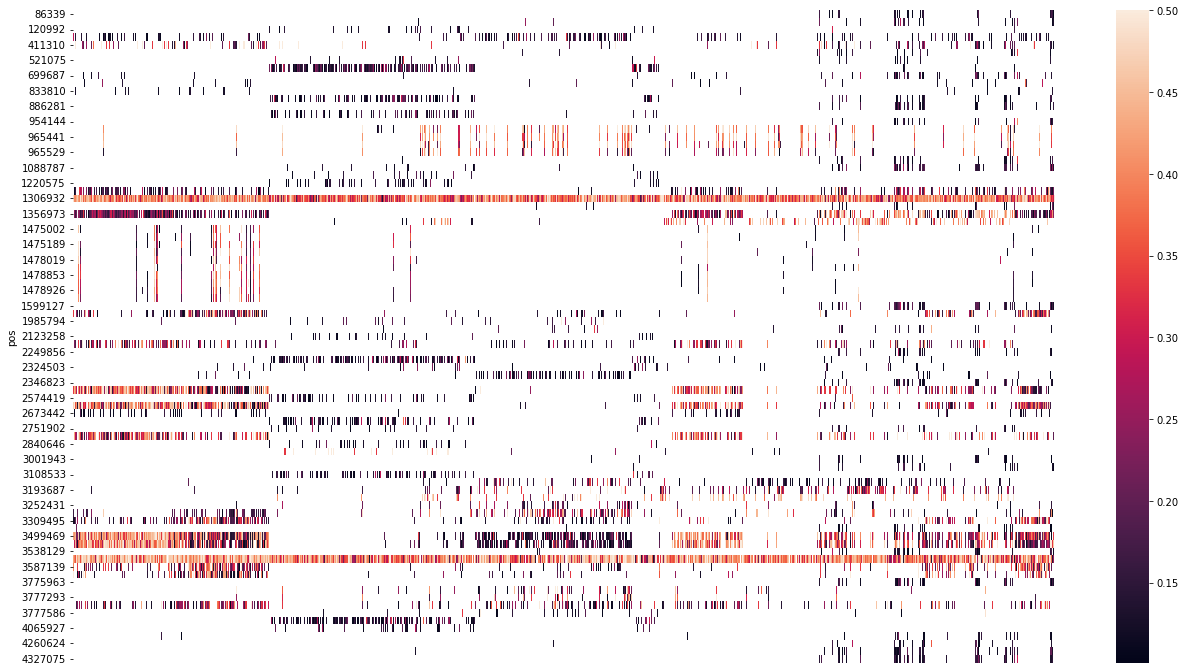

In [184]:
plt.figure(figsize=(22,12))
sns.heatmap(hdf,xticklabels=False)

In [149]:
H=hdf.fillna(0)
#cg = sns.clustermap(H,xticklabels=False,yticklabels=False,
#                    cmap='Reds',cbar_pos=None,figsize=(17,10)) #row_colors=[colors1,colors2]